- OpenClassrooms Project 7, Data Scientist
- Author : Oumeima EL GHARBI
- Date : November, December 2022

### Importing libraries

In [1]:
%reset -f

import warnings
warnings.filterwarnings(action="ignore")

# to compute time of pipeline
from time import time, strftime, gmtime

import pandas as pd
from os import listdir
from os.path import isfile, join

import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from evaluation_metrics import *

%matplotlib inline
%autosave 300

Autosaving every 300 seconds


In [2]:
import sys
print("Python version {}.{}.{}".format(str(sys.version_info[0]), str(sys.version_info[1]), str(sys.version_info[2])))

Python version 3.9.7


In [3]:
# Starting time
t0 = time()

input_path = "./dataset/cleaned/"
output_path = "./dataset/cleaned/"

## Part III : Prediction

#### Loading dataset

In [4]:
train_file = input_path + "train.csv"
val_file = input_path + "val.csv"

train = pd.read_csv(train_file, sep=",")
val = pd.read_csv(val_file, sep=",")

target = "TARGET"

#X_train = train.loc[:, train.columns != 'TARGET'].iloc[:, 1:]
#X_val = val.loc[:, val.columns != 'TARGET'].iloc[:, 1:] # all rows, not target and removes SK_ID_CURR the PK

# all rows, not target and removes SK_ID_CURR the PK
features = [f for f in train.columns if f not in ['TARGET','SK_ID_CURR']] # ,'SK_ID_BUREAU','SK_ID_PREV','index' / deleted
X_train = train[features]
X_val = val[features]

y_train = train[target]
y_val = val[target]

In [5]:
print("The shape of the training matrix :", X_train.shape, "and this is the shape of the target vector :", y_train.shape)
print("The shape of the test matrix :", X_val.shape, "and this is the shape of the target vector :", y_val.shape)

The shape of the training matrix : (215254, 777) and this is the shape of the target vector : (215254,)
The shape of the test matrix : (92253, 777) and this is the shape of the target vector : (92253,)


#### Baseline : DummyClassifier

In [6]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)

# save the model to disk
print("Saving model with joblib")
filename_joblib = 'models/Dummy.joblib'
joblib.dump(dummy_clf, filename_joblib)

y_pred = dummy_clf.predict(X_val)

Saving model with joblib


              precision    recall  f1-score   support

           0       0.92      1.00      0.96     84811
           1       0.00      0.00      0.00      7442

    accuracy                           0.92     92253
   macro avg       0.46      0.50      0.48     92253
weighted avg       0.85      0.92      0.88     92253

ROC-AUC 0.5


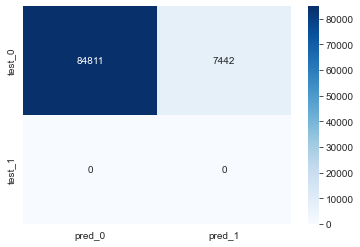

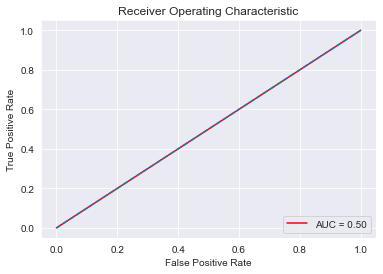

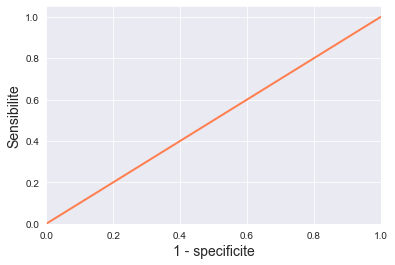

In [7]:
evaluate_classification(y_val, y_pred, y_pred_proba=y_pred)

In [8]:
results = evaluate_models("Dummy", results, y_val, y_pred)

Prediction for :  TARGET


,Model,ROC-AUC,Precision,Recall,F1-score,F1-score weighted,Accuracy
0,Dummy,0.5,0.0,0.0,0.0,0.881,0.919


#### Hist Boost ** rename

In [9]:
from sklearn.ensemble import HistGradientBoostingClassifier
estimator = HistGradientBoostingClassifier()
estimator.fit(X_train, y_train)

# save the model to disk
print("Saving model with joblib")
filename_joblib = 'models/HistBoost.joblib'
joblib.dump(estimator, filename_joblib)

Saving model with joblib


['models/HistBoost.joblib']

In [10]:
y_pred = estimator.predict(X_val)

In [11]:
y_pred_proba = estimator.predict_proba(X_val)[:, 1]

In [12]:
y_pred_proba

array([0.18209269, 0.01114468, 0.13057951, ..., 0.03926476, 0.09137202,
       0.06307749])

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     84811
           1       0.57      0.04      0.07      7442

    accuracy                           0.92     92253
   macro avg       0.75      0.52      0.52     92253
weighted avg       0.89      0.92      0.89     92253

ROC-AUC 0.518


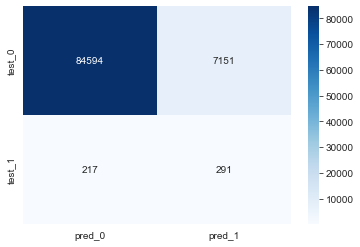

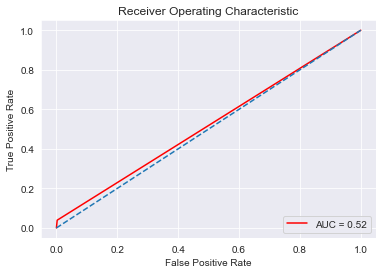

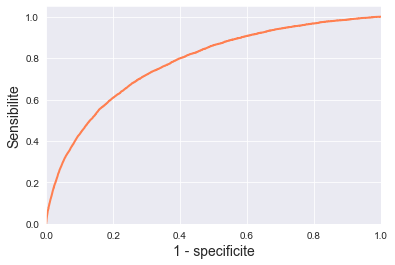

In [13]:
evaluate_classification(y_val, y_pred, y_pred_proba=y_pred_proba)

In [14]:
results = evaluate_models("HistBoost", results, y_val, y_pred)

Prediction for :  TARGET


,Model,ROC-AUC,Precision,Recall,F1-score,F1-score weighted,Accuracy
0,HistBoost,0.518,0.573,0.039,0.073,0.887,0.920
0,Dummy,0.500,0.000,0.000,0.000,0.881,0.919


#### Logistic Regression ? clean NaN + Std

In [15]:
from sklearn.linear_model import LogisticRegression
estimator = LogisticRegression(solver="liblinear")

#### SVM ? clean NaN + Std and no infinity !!

In [16]:
from sklearn.svm import SVC
estimator = SVC(kernel='rbf') # by default

In [17]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
#clf.fit(X_train, y_train)

#### LightGBM

In [18]:
import lightgbm as lgb
import re
import gc

# LightGBM parameters found by Bayesian optimization
clf = lgb.LGBMClassifier(
    nthread=4,
    n_estimators=10000,
    learning_rate=0.02,
    num_leaves=34,
    colsample_bytree=0.9497036,
    subsample=0.8715623,
    max_depth=8,
    reg_alpha=0.041545473,
    reg_lambda=0.0735294,
    min_split_gain=0.0222415,
    min_child_weight=39.3259775,
    silent=-1,
    verbose=-1, )

X_train = X_train.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))
X_val = X_val.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))
# train_y = train_y.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

print("Training LGBM")
clf.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)],
        eval_metric='auc', verbose=200, early_stopping_rounds=200)

# save the model to disk
print("Saving LGBM with joblib")
filename_joblib = 'models/LGBMClassifier.joblib'
joblib.dump(clf, filename_joblib)


Training LGBM
[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.802201	training's binary_logloss: 0.233877	valid_1's auc: 0.772589	valid_1's binary_logloss: 0.242068
[400]	training's auc: 0.827083	training's binary_logloss: 0.223254	valid_1's auc: 0.782725	valid_1's binary_logloss: 0.238047
[600]	training's auc: 0.844301	training's binary_logloss: 0.216111	valid_1's auc: 0.786126	valid_1's binary_logloss: 0.236819
[800]	training's auc: 0.858226	training's binary_logloss: 0.210231	valid_1's auc: 0.7878	valid_1's binary_logloss: 0.236209
[1000]	training's auc: 0.86998	training's binary_logloss: 0.205121	valid_1's auc: 0.788774	valid_1's binary_logloss: 0.235867
[1200]	training's auc: 0.880232	training's binary_logloss: 0.200433	valid_1's auc: 0.789329	valid_1's binary_logloss: 0.235674
[1400]	training's auc: 0.889847	training's binary_loglos

KeyboardInterrupt: 

In [21]:
# load model
print("Loading LGBM")
clf = joblib.load('models/LGBMClassifier.joblib')

y_pred = clf.predict(X_val)
y_pred_proba = clf.predict_proba(X_val)[:, 1] # we take the prediction for the class 1
evaluate_classification(y_val, y_pred, y_pred_proba=y_pred_proba)
results = evaluate_models("LightGBM", results, y_val, y_pred)

Loading LGBM


KeyboardInterrupt: 

Loading LGBM
              precision    recall  f1-score   support

           0       0.93      1.00      0.96     84811
           1       0.83      0.10      0.17      7442

    accuracy                           0.93     92253
   macro avg       0.88      0.55      0.57     92253
weighted avg       0.92      0.93      0.90     92253

ROC-AUC 0.548


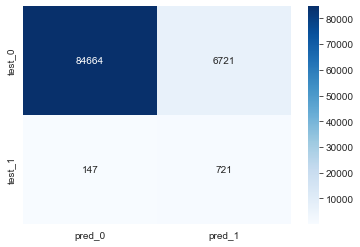

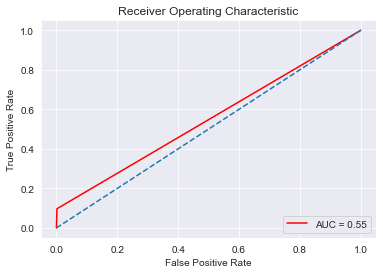

Prediction for :  TARGET


,Model,ROC-AUC,Precision,Recall,F1-score,F1-score weighted,Accuracy
0,LightGBM_0,0.548,0.831,0.097,0.174,0.897,0.926
0,HistBoost,0.518,0.573,0.039,0.073,0.887,0.920
0,Dummy,0.500,0.000,0.000,0.000,0.881,0.919


Loading LGBM


FileNotFoundError: [Errno 2] No such file or directory: 'models/LGBM/LGBMClassifier_fold_1.joblib'

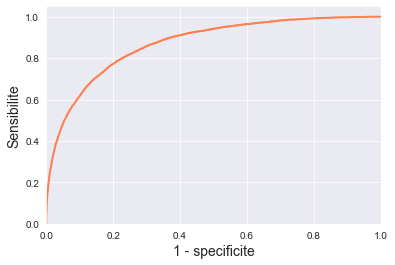

In [22]:
for i in range(10):
    # load model
    print("Loading LGBM")
    clf = joblib.load('models/LGBM/LGBMClassifier_fold_{}.joblib'.format(i))

    y_pred = clf.predict(X_val)
    y_pred_proba = clf.predict_proba(X_val)[:, 1] # we take the prediction for the class 1
    evaluate_classification(y_val, y_pred, y_pred_proba=y_pred_proba)
    results = evaluate_models("LightGBM_{}".format(i), results, y_val, y_pred)

In [ ]:
# save the model to disk
#print("Saving best model with joblib")
#filename_joblib = 'models/best_model.joblib'
#joblib.dump(clf, filename_joblib)

#### CV
#### GridSearch
#### SMOTE

#### (MLflow tracking)


In [ ]:
# End of notebook time
t1 = time()
print("computing time : {:8.6f} sec".format(t1 - t0))
print("computing time : " + strftime('%H:%M:%S', gmtime(t1 - t0)))